# Batch Slide label cropping

----
### Import dependancies

In [1]:
import pytesseract as pytess
import numpy as np 
import skimage 
import scipy 
import aicsimageio
import os 
import tifffile as tf
from PIL import Image
import tkinter as tk 
import pandas as pd
import matplotlib.pyplot as plt
from tkinter import filedialog

In [2]:
pytess.pytesseract.tesseract_cmd = r'C:/Users/rcorbyn/AppData/Local/Programs/Tesseract-OCR/tesseract.exe'

----
### Get slide image

In [7]:
# # # Creates dialogue to ask directory
# # # Get the folder containing the image stack. 
root = tk.Tk()
root.attributes('-topmost', True)
root.withdraw() # Stops a second window opening
folder = filedialog.askdirectory(title = 'Select Stack file')

files = os.listdir(folder)

print(folder)
print(files)

N:/RCORBYN/User_Data/Current_Projects/20241118_PlateScanner/Raw_Slide_Images
['labelled_Kyi_R09_221024-263.png', 'labelled_R09_Kyi_231024-009.png', 'labelled_Kyi_R09_221024-233.png', 'labelled_Kyi_R09_221024-280.png', 'labelled_R09_Kyi_231024-008.png', 'labelled_Kyi_R09_221024-039.png', 'labelled_R09_Kyi_231024-028.png', 'labelled_Kyi_R09_221024-025.png', 'labelled_Kyi_R09_221024-057.png', 'labelled_R09_Kyi_231024-013.png', 'labelled_Kyi_R09_221024-198.png', 'labelled_Kyi_R09_221024-200.png', 'labelled_Kyi_R09_221024-221.png', 'labelled_Kyi_R09_221024-125.png', 'labelled_Kyi_R09_221024-099.png', 'labelled_Kyi_R09_221024-152.png', 'labelled_Kyi_R09_221024-240.png', 'labelled_Kyi_R09_221024-107.png', 'labelled_Kyi_R09_221024-195.png', 'labelled_R09_Kyi_231024-043.png', 'labelled_R09_Kyi_231024-052.png', 'labelled_Kyi_R09_221024-179.png', 'labelled_Kyi_R09_221024-229.png', 'labelled_Kyi_R09_221024-243.png', 'labelled_Kyi_R09_221024-008.png', 'labelled_Kyi_R09_221024-169.png', 'labelled_Ky

----
### Letter segmentation

In [11]:
results = []

for file in files:
    ####
    if file[-4:] == '.png':
        # Open up the image
        rgba_image = Image.open(folder + '/' + file)
        im_data = rgba_image.convert('RGB')
        # Reduce the image to the lowest 
        # number of dimensions. 
        im_data = np.array(im_data)
        
        #######
        # Perform edge detection
        edges = skimage.filters.sobel( np.sum(im_data, axis = 2) )
        
        #####
        # Threshold the image to remove most of the 
        # unimportant information from the image.
        
        # Find the threshold values
        threshold_val = skimage.filters.threshold_otsu(edges)
        edges[edges < threshold_val] = 0
        
        # Fill the binary masks of the letters
        fill_string = scipy.ndimage.binary_fill_holes(edges)
        
        # Invert the image and multiply by the letter
        # mask to get only the letters in the image. 
        invert = fill_string * skimage.util.invert( im_data[:, :, 0] )
        #####
        # Create a binary image from the inverted letters
        binary = np.array(invert)
        binary[binary>0] = 1
        
        # create labels from the binary image. 
        labels = skimage.measure.label(binary)
        
        # Get properties of the letters and remaining masks. 
        region_props = pd.DataFrame( skimage.measure.regionprops_table(
                        labels, properties = {'label', 'area', 
                        'axis_minor_length', 'axis_major_length'}) )
        
        # Create a mask of zeros
        filtered_image = np.zeros(im_data.shape)
        
        # Loop around all labels. 
        for i in range(region_props.shape[0]): 
            # Find the positon of mask i in the label image. 
            mask_pos = np.where(labels == region_props['label'].iloc[i])
            # Find the maximum and minimum height and width of the masks. 
            delta_x = np.abs( np.min(mask_pos[0]) - np.max(mask_pos[0]) ) 
            delta_y = np.abs( np.min(mask_pos[1]) - np.max(mask_pos[1]) ) 
            # If the mask is too long or high, remove 
            # Also remove if the area is too small. 
            if delta_x  <= 75 and delta_y <= 75 and region_props['area'].iloc[i] > 100: 
                # keep the mask. 
                filtered_image[mask_pos[0], mask_pos[1]] = skimage.util.invert(
                                            im_data[mask_pos[0], mask_pos[1], :] )
        
        filtered_image = np.array(filtered_image, dtype = 'uint8')
        
        filtered_image[filtered_image>150] = 255
        filtered_image[filtered_image<150] = 0
        
        text = pytess.image_to_string(filtered_image)
    
        text = text.replace( chr(10), '_' )
        text = text.replace( ' ' , '_' )
        text = text.replace( '/', '_' )
        text = text.replace('colorslide', '')
    
        print(text)

F_4_80__IZY__IZY25_2b_24_19949_2_KY_ROS_LF_
4_CASP3__LIV__24_14527_KY_ROO_24x_876_
H&E__IZY__IZY25_2e_24_19953_2_KY_ROO_LF__Celeurslides_
FOXP3__IZY__IZY25_2__24_1993_1_ROS_LF_
CASP3_LIV_IBLACK__IZY24_9m_24_14543__KY_ROO_24x_876_
BRDU_LIV__IZY__IZY25_2_24_19938_KY_ROO_LF_
CD8a_LIV_IBLACK__IZY24_9_24_14541__KY_ROO_=_24x_876_
FOXP3__IZY__IZY25_2p_24_19959_1_KY_ROO_LF_
BRDU_LIV_IZY__IZY25_2d_24_19950_KY_ROO_LF_
t_mses_LIV__BLACK_IZY¥24_9)__24_1_4537_ROQ9_24x_876_
CD8a_LIV_IZY__IZY25_2f_24_19954__KY_ROS_LF_
CD8a__IZY__IZY25_2f_24_19955_2_KY_ROS_LF_
H&E__IZY__IZY25_2n_24_19945_2_KY_ROO_LF__Celeurshdes_
GHA2X__IZY__IZY25_2a_24_19947_2_KY_ROO_LF_
CASP3_LIV_IZY__IZY25_2f_24_19954_KY_ROO_LF_
GRANZ_B__IZY__IZY25_2a_24_19947_2_KY_ROO_LF_
H&E_LIV_IZY__IZY25_2p_24_19958__KY_ROO_LF__Celeurslides_
CASP3__IZY__IZY25_2p_24_19959_2_KY_ROO_LF_
CD8a_LIV_IZY__IZY25_2e_24_19952_KY_ROO_LF_
FOXP3_LIV_IBLACK__IZY24_9I_24_14541__KY_ROQ_24x_876_
F4_80_LIV_IBLACK__IZY24_9b_24_14523__KY_ROO_24x_876_
CD8a__IZY__IZY

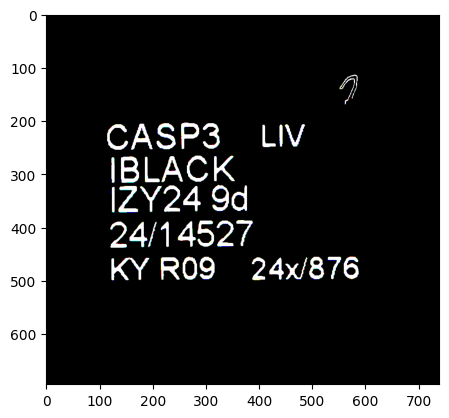

In [5]:
im = Image.fromarray(filtered_image)
# im.save("your_file.jpeg")
plt.imshow(im)

In [6]:
text = text.replace( chr(10), '_' )
text = text.replace( ' ' , '' )
text = text.replace( '/', '_' )
text = text.replace('colorslide', '')
text

'4_CASP3_LIV__24_14527_KYROO24x_876_'